## Imports

In [22]:
import sys, os
import pandas as pd
import polars as pl
import numpy as np
from dotenv import load_dotenv

sys.path.append('/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting')
# when running on JupyterHub the dot-env-path needs to be adapted
load_dotenv("../.env")

datetime_format = "%Y-%m-%d %H:%M%z"

%load_ext autoreload

In [48]:
%autoreload

## Calculate Region Proportions

what are the weights of the regions of the smart meter locations

and what weather stations and weather forecast grid points can we utilize for a weighted forecast

## Loading and Cleaning data

In [23]:
from src.neuro_symbolic_demand_forecasting.darts.cleaning import *

df = pl.read_csv('../unclean_data/2023_07_data.csv', columns=['EAN_SHA256', 'LDN', 'ODN', 'READINGDATE'],
                 try_parse_dates=True,
                 new_columns=[f.lower() for f in ['EAN_SHA256', 'LDN', 'ODN', 'READINGDATE']])

### Dividing data into PV and non-PV cluster

In [24]:
sum_odn = df.group_by('ean_sha256').agg(pl.col('odn').sum())

pv = df.filter(pl.col('ean_sha256').is_in(sum_odn.filter(pl.col('odn') > 0)['ean_sha256']))
non_pv = df.filter(pl.col('ean_sha256').is_in(sum_odn.filter(pl.col('odn') <= 0)['ean_sha256']))

print(pv, non_pv)
len(pv) + len(non_pv), len(df)

shape: (17_605_115, 4)
┌───────────────────────────────────┬──────────┬──────────┬─────────────────────────┐
│ ean_sha256                        ┆ ldn      ┆ odn      ┆ readingdate             │
│ ---                               ┆ ---      ┆ ---      ┆ ---                     │
│ str                               ┆ i64      ┆ i64      ┆ datetime[μs, UTC]       │
╞═══════════════════════════════════╪══════════╪══════════╪═════════════════════════╡
│ 78806E8B71A33EA746793D7D849EF532… ┆ 6293390  ┆ 5623217  ┆ 2023-07-18 04:15:00 UTC │
│ DC629842438D51C735BBE6BF522B9045… ┆ 10903890 ┆ 1658369  ┆ 2023-07-18 04:15:00 UTC │
│ 6421A5E6058DFAEDB94BAE4109C75B02… ┆ 31759843 ┆ 16       ┆ 2023-07-18 04:15:00 UTC │
│ CC217EE6C87269E7AE3A42625B99AFA4… ┆ 17328222 ┆ 2369111  ┆ 2023-07-18 04:15:00 UTC │
│ 672E6875A463F86AB3FA48B6FC2D1209… ┆ 7291510  ┆ 1        ┆ 2023-07-18 04:15:00 UTC │
│ …                                 ┆ …        ┆ …        ┆ …                       │
│ E029AC2B688E7165556D1A4427B19

(29458356, 29458356)

### Cleaning dfs

In [25]:
cleaned_nonpv_df = clean_data(non_pv)
cleaned_nonpv_df.plot()

Filtering out 2023-07-31 21:45:00+00:00 2023-06-30 21:00:00+00:00 2980.0
Filtering out timeseries with less than 2980.0
Generating intervals
Aggregating data into one timeseries: cols: gross
Checking for outliers above 8795.2 and below 507.25
Linearly interpolation outliers detected at the indices: shape: (95,)
Series: 'index' [u32]
[
	0
	171
	172
	196
	270
	…
	2954
	2955
	2957
	2960
	2964
]


Python(23619) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(23626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(23638) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


:Curve   [index]   (gross)

In [26]:
cleaned_pv_df = clean_data(pv)
cleaned_pv_df.plot()

Filtering out 2023-07-31 21:45:00+00:00 2023-06-30 21:00:00+00:00 2980.0
Filtering out timeseries with less than 2980.0
Generating intervals
Aggregating data into one timeseries: cols: gross
Checking for outliers above 334720.7 and below -652879.375
Linearly interpolation outliers detected at the indices: shape: (7,)
Series: 'index' [u32]
[
	633
	634
	635
	636
	637
	638
	1221
]


:Curve   [index]   (gross)

In [27]:
month  = '07'

cleaned_pv_df.write_csv(f'../data/2023_{month}_cleaned_pv.csv')
cleaned_nonpv_df.write_csv(f'../data/2023_{month}_cleaned_non_pv.csv')

In [46]:
from darts import TimeSeries

nonpv_ts = TimeSeries.from_dataframe(cleaned_nonpv_df.to_pandas().set_index('readingdate'))


The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.12/lib/python3.12/site-packages/darts/timeseries.py:737: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

In [51]:
nonpv_ts.add_datetime_attribute('weekday',one_hot=True)

<TimeSeries (DataArray) (readingdate: 2884, component: 8, sample: 1)> Size: 185kB
array([[[1.48538e+05],
        [0.00000e+00],
        [0.00000e+00],
        ...,
        [0.00000e+00],
        [0.00000e+00],
        [0.00000e+00]],

       [[1.61465e+05],
        [0.00000e+00],
        [0.00000e+00],
        ...,
        [0.00000e+00],
        [0.00000e+00],
        [0.00000e+00]],

       [[1.54081e+05],
        [0.00000e+00],
        [0.00000e+00],
        ...,
...
        ...,
        [1.00000e+00],
        [0.00000e+00],
        [0.00000e+00]],

       [[1.28524e+05],
        [0.00000e+00],
        [0.00000e+00],
        ...,
        [1.00000e+00],
        [0.00000e+00],
        [0.00000e+00]],

       [[1.35611e+05],
        [0.00000e+00],
        [0.00000e+00],
        ...,
        [1.00000e+00],
        [0.00000e+00],
        [0.00000e+00]]])
Coordinates:
  * readingdate  (readingdate) datetime64[ns] 23kB 2023-05-31T21:00:00 ... 20...
  * component    (component) object 64B 'gross' 'weekday_0' ... 'weekday_6'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## Pulling weather data

In [3]:
actuals = pl.read_csv('./2023-06-amsterdam-actuals.csv')

actuals.columns

actual_cols = [ pl.col(c) for c in [
 'datetime_from',
 'wind_speed',
 'wind_gust_speed',
 'air_temperature',
 'relative_humidity',
 'air_pressure',
 'visibility',
#  'rain_gauge_precipitation_duration',
 'cloud_cover',
#  'pws_precipitation_intensity',
#  'pws_precipitation_duration',
 'global_radiation',
 'dew_point_temperature',
 ]]

selected_actuals = actuals.select(actual_cols)
selected_actuals = selected_actuals.with_columns(pl.col('datetime_from').str.to_datetime())
selected_actuals

datetime_from,wind_speed,wind_gust_speed,air_temperature,relative_humidity,air_pressure,visibility,cloud_cover,global_radiation,dew_point_temperature
datetime[μs],f64,f64,f64,f64,f64,f64,str,f64,f64
2023-06-01 00:00:00,5.23,7.65,284.45,0.85,102491.0,31500.0,null,0.0,282.15
2023-06-01 00:10:00,5.28,8.62,284.55,0.85,102481.0,32200.0,null,0.0,282.15
2023-06-01 00:20:00,5.87,8.84,284.55,0.86,102471.0,26600.0,null,0.0,282.25
2023-06-01 00:30:00,6.16,9.28,284.45,0.86,102471.0,27600.0,null,0.0,282.25
2023-06-01 00:40:00,5.85,9.17,284.35,0.86,102471.0,26600.0,null,0.0,282.15
…,…,…,…,…,…,…,…,…,…
2023-07-29 23:10:00,4.62,6.35,289.85,0.88,100772.0,14900.0,"""2.0""",0.0,287.85
2023-07-29 23:20:00,5.15,6.55,289.95,0.87,100772.0,14300.0,"""6.0""",0.0,287.85
2023-07-29 23:30:00,4.9,6.12,289.95,0.87,100782.0,15000.0,"""8.0""",0.0,287.95


In [4]:
weather_df = pl.read_csv('../2023_weather_data_06_run_summer.csv', try_parse_dates=True).sort('valid_datetime')#.filter((pl.col('valid_datetime') < max_date) & (pl.col('valid_datetime') >= min_date))

selected_weather = weather_df.select(
    pl.col('valid_datetime'), pl.col('wind_speed_10m'), pl.col('t_instant_ground_2m'),  
    pl.col('grad_accum_ground_0m'),  pl.col('rain_instant_ground_0m'), pl.col('pres_instant_ground_0m'),
    pl.col('wind_blast_speed_10m')
)
selected_weather

# selected_weather.with_columns(pl.col('grad_accum_ground_0m') < 0).select(pl.col('valid_datetime'), pl.col('grad_accum_ground_0m'))

valid_datetime,wind_speed_10m,t_instant_ground_2m,grad_accum_ground_0m,rain_instant_ground_0m,pres_instant_ground_0m,wind_blast_speed_10m
"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64
2023-04-01 00:00:00 UTC,5.08021,282.15723,0.0,0.00009,98975.19,10.466365
2023-04-01 01:00:00 UTC,4.670426,282.03906,0.0,0.000083,98986.19,9.381132
2023-04-01 02:00:00 UTC,4.5113754,281.7544,0.0,0.000088,98998.44,8.600689
2023-04-01 03:00:00 UTC,4.049578,281.49512,0.0,0.000094,99022.5,8.31484
2023-04-01 04:00:00 UTC,3.5291646,281.38184,0.0,0.000231,99044.81,7.4436874
…,…,…,…,…,…,…
2023-07-31 19:00:00 UTC,4.1694837,290.3694,25900.188,0.000036,100127.75,8.043049
2023-07-31 20:00:00 UTC,3.9396036,290.45752,890.4375,1.1921e-7,100079.75,7.7695036
2023-07-31 21:00:00 UTC,3.7858133,290.16504,0.0,0.0,100024.5,7.3689775


In [24]:
selected_weather.plot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

## Data Prep

In [91]:
cleaned_df.write_csv('2023_06_cleaned_data.csv')

In [10]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler


sm = pd.read_csv('2023_06_cleaned_data.csv', index_col=None, parse_dates=['readingdate']).set_index('readingdate')

wf = pd.read_csv('../2023_weather_data_06_run_summer.csv', index_col=None, parse_dates=['valid_datetime']).set_index(
    'valid_datetime')
wf = wf[['wind_speed_10m', 'grad_accum_ground_0m', 'pres_instant_ground_0m', 't_instant_ground_2m']]
wf = wf.resample('15min').ffill()

wa = pd.read_csv('2023-06-amsterdam-actuals.csv', index_col=None, parse_dates=['datetime_from']).set_index('datetime_from')
wa = wa[['wind_speed', 'global_radiation', 'air_pressure', 'air_temperature']]
wa = wa.resample('15min').mean()

# if we are training on the solar cluster we want -1 to 1 range, else just 0 to 1
smart_meter_scaler = Scaler(MinMaxScaler(feature_range=(-1, 1)))
smart_meter_ts = smart_meter_scaler.fit_transform(TimeSeries.from_dataframe(sm))

weather_forecast_scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))
weather_forecast_ts = weather_forecast_scaler.fit_transform(TimeSeries.from_dataframe(wa))

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


In [5]:
from sklearn.preprocessing import MinMaxScaler

meter_data_scaler = MinMaxScaler()
weather_data_scaler = MinMaxScaler()
actuals_data_scaler = MinMaxScaler()

In [6]:
scaled_meter = cleaned_df.to_pandas()

scaled_meter.set_index('readingdate', inplace=True)

scaled_meter = pd.DataFrame(meter_data_scaler.fit_transform(scaled_meter.values), columns=scaled_meter.columns, index=scaled_meter.index)



scaled_actuals = selected_actuals.to_pandas()
scaled_actuals.set_index('datetime_from', inplace=True)
scaled_actuals = pd.DataFrame(actuals_data_scaler.fit_transform(scaled_actuals.values), columns=scaled_actuals.columns, index=scaled_actuals.index)
scaled_actuals = scaled_actuals.resample('15min').mean()


scaled_weather = selected_weather.to_pandas()
scaled_weather.set_index('valid_datetime', inplace=True)
scaled_weather = pd.DataFrame(weather_data_scaler.fit_transform(scaled_weather.values), columns=scaled_weather.columns, index=scaled_weather.index)
scaled_weather = scaled_weather.resample('15min').ffill()

In [8]:
from darts import TimeSeries

# scaled_weather.index.min(), scaled_weather.index.max(), scaled_meter.index.min(), scaled_meter.index.max()
set(scaled_meter[:-3].index.tolist()).difference(scaled_weather.index.tolist())

meter_ts = TimeSeries.from_dataframe(scaled_meter) # last three are not in weather_ts so we are skipping them
weather_ts = TimeSeries.from_dataframe(scaled_weather, freq='15min')
actuals_ts = TimeSeries.from_dataframe(scaled_actuals, freq='15min')

len(meter_ts), len(weather_ts), len(actuals_ts)

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.12/lib/python3.12/site-packages/darts/timeseries.py:737: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

(2884, 11709, 5664)

### Data Split

In [9]:
train_meter, val_meter = meter_ts.split_after(0.8)

## Linear Regression

In [60]:
from darts.models import RegressionModel

regr_model = RegressionModel(
    lags=5*24*4,
    lags_past_covariates=5*24*4,
    # lags_future_covariates=(),
    output_chunk_length=int(0.5*24*4),
    add_encoders={
        'tz': 'UTC'
    }

)

regr_model = regr_model.fit(train_meter, past_covariates=weather_ts)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

<Axes: xlabel='readingdate'>

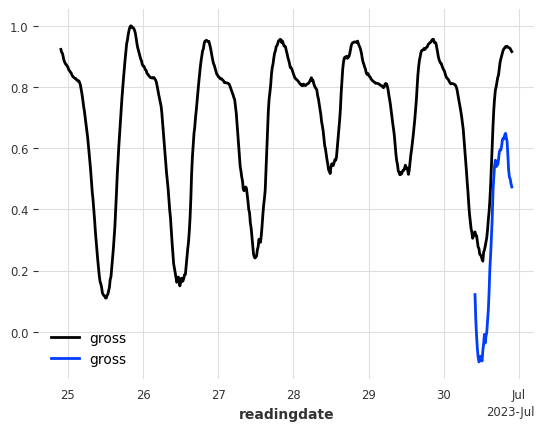

In [59]:
forecast, actual  = val_meter[:-48], val_meter[-48:]

val_meter.plot()

regr_model.predict(48, forecast, past_covariates=weather_ts).plot()

In [39]:
backtest = regr_model.historical_forecasts(
    meter_ts,
    past_covariates=weather_ts,
    start=val_meter.start_time(),
    forecast_horizon=96,
    stride=96,
    last_points_only=False,
    retrain=False,
    verbose=True,
)

  0%|          | 0/1 [00:00<?, ?it/s]

### Evaluation

MAPE = 65.43%
SMAPE = 98.87%
MAE = 0.30%


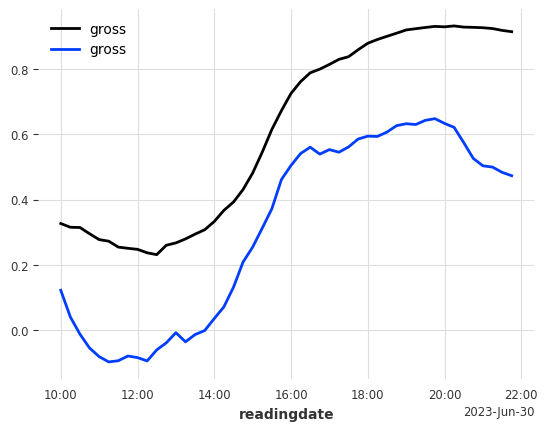

In [57]:
from darts.metrics import mape, smape, mae

# regr_model.predict(1)
# eval_model(regr_model, val_weather)

# plot acutals against the predicted horizon
forecast, actual  = val_meter[:-48], val_meter[-48:]

actual.plot()

pred = regr_model.predict(48, forecast, weather_ts)
pred.plot()

print("MAPE = {:.2f}%".format(mape(actual, pred)))
print("SMAPE = {:.2f}%".format(smape(actual, pred)))
print("MAE = {:.2f}%".format(mae(actual, pred)))


In [21]:
from darts.metrics import rmse

# We first set aside the first 80% as training series:

def eval_model(model, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=meter_ts, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=1)
    
    meter_ts[-len(backtest)-100:].plot()
    backtest.plot(label='backtest (n=10)')
    print('Backtest RMSE = {}'.format(rmse(meter_ts, backtest)))

## Py Torch Settings 

### Custom Loss

In [56]:
import torch
import torch.nn as nn

# Define your custom loss function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        # Define your loss components here

    def forward(self, output, target):
        # Calculate your custom loss
        # print('outputted', output)
        # print('target', target)
        loss = torch.mean((output - target)**2)  # Example custom loss (MSE)
        return loss
    

torch_kwargs = {
    'loss_fn': CustomLoss()
}


### Early stopping

In [12]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper]}

## LSTM with Darts

In [35]:
from darts.models import (
    NBEATSModel,
    BlockRNNModel
)

model_name = "BlockRNN_test"
model_lstm = BlockRNNModel(
    model="LSTM",
    input_chunk_length=24,
    output_chunk_length=4,
    n_epochs=10,
    random_state=0,
    model_name=model_name,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    force_reset=True,
    **torch_kwargs
)

In [38]:
model_lstm.fit(
    train_meter,
    past_covariates=weather_ts,
    val_series=val_meter,
    val_past_covariates=weather_ts,
    # future_covariates=actuals_ts
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `BlockRNNModel.load_weights()` to load the weights for fine-tuning.
/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting/notebooks/darts_logs/BlockRNN_test/checkpoints exists and is not empty.

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | CustomLoss       | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.4 K 
4 | fc            | S

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=24, output_chunk_length=4, n_epochs=10, random_state=0, model_name=BlockRNN_test, save_checkpoints=True, force_reset=True, loss_fn=CustomLoss())

### Evaluation

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE = 29.01%
SMAPE = 22.99%
MAE = 0.12%


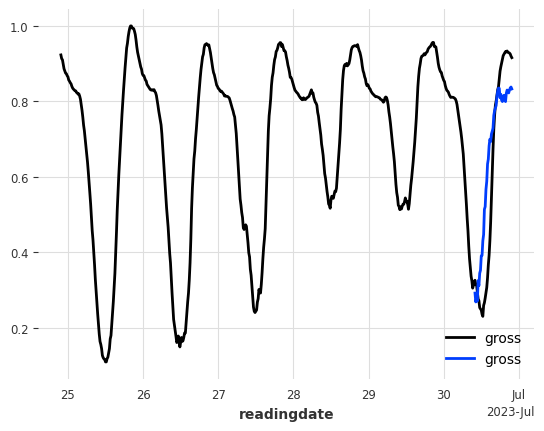

In [62]:
from darts.metrics import mape, smape, mae

# regr_model.predict(1)
# eval_model(regr_model, val_weather)

# plot acutals against the predicted horizon
forecast, actual  = val_meter[:-48], val_meter[-48:]

val_meter.plot()

pred = model_lstm.predict(48, forecast, weather_ts)
pred.plot()

print("MAPE = {:.2f}%".format(mape(actual, pred)))
print("SMAPE = {:.2f}%".format(smape(actual, pred)))
print("MAE = {:.2f}%".format(mae(actual, pred)))


## TFTModel



In [83]:
from darts.models import TFTModel
from darts import TimeSeries


input_chunk_length = 5 * 24 * 4
forecast_horizon = 1 * 24 * 4
# use `add_encoders` as we don't have future covariates
# from Paper
# model = TFTModel(
#     input_chunk_length=input_chunk_length, # encoder_length
#     output_chunk_length=forecast_horizon,
#     num_attention_heads=2,
#     hidden_size=60,
#     hidden_continuous_size=30,
#     lstm_layers=2,
#     batch_size=1024,
#     n_epochs=5,
#     dropout=0.7,
#     # add_encoders={"cyclic": {"future": ["month"]}},
#     add_relative_index=False,
#     optimizer_kwargs={"lr": 0.001}, # learning rate
#     use_static_covariates=False,
#     random_state=42,
# )

model= TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    # hidden_size=32,
    # lstm_layers=2,
    # batch_size=16,
    n_epochs=5,
    # dropout=0.1,
    # add_encoders={"cyclic": {"future": ["month"]}},
    # use_static_covariates=False,
    # add_relative_index=False,
    # optimizer_kwargs={"lr": 1e-3},
    random_state=42,
    use_static_covariates=False,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    **torch_kwargs # custom loss
)

### Training

In [37]:
print(train_meter.time_index.min(), train_meter.time_index.max())
print(weather_ts.time_index.min(), weather_ts.time_index.max())
print(actuals_ts.time_index.min(), actuals_ts.time_index.max())

2023-06-01 00:00:00 2023-06-24 21:30:00
2023-04-01 00:00:00 2023-07-31 23:00:00
2023-06-01 00:00:00 2023-07-29 23:45:00


In [81]:
actuals_ts.columns, weather_ts.columns

(Index(['wind_speed', 'wind_gust_speed', 'air_temperature', 'relative_humidity',
        'air_pressure', 'visibility', 'cloud_cover', 'global_radiation',
        'dew_point_temperature'],
       dtype='object', name='component'),
 Index(['wind_speed_10m', 't_instant_ground_2m', 'grad_accum_ground_0m',
        'rain_instant_ground_0m', 'pres_instant_ground_0m',
        'wind_blast_speed_10m'],
       dtype='object', name='component'))

In [17]:
# train_meter = train_meter[12:]
# weather_ts = weather_ts[:8496]
# weather_ts = weather_ts[5856:]
# len(train_meter), len(weather_ts[:8496]), len(actuals_ts)

In [84]:
dummy_covariate = pd.Series(0, index=train_meter.time_index)  # Adjust the constant value as needed


wts = weather_ts[['wind_speed_10m', 'grad_accum_ground_0m', 'pres_instant_ground_0m', 't_instant_ground_2m']]
ats = actuals_ts[['wind_speed', 'global_radiation', 'air_pressure', 'air_temperature']]
model.fit(
    train_meter, 
    past_covariates=ats, 
    future_covariates=wts, 
    val_series=val_meter,
    val_past_covariates=ats,
    
    val_future_covariates=wts, 
    verbose=True,
    
    # trainer=pl_trainer_kwargs
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | CustomLoss                       | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 5.9 K 
6  | decoder_vsn                       | _VariableSelectionNetwork        | 2.4 K 
7  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
8  | static_cont

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=CustomLoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=False, input_chunk_length=480, output_chunk_length=96, n_epochs=5, random_state=42, save_checkpoints=True)

### Evaluation

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE = 13.96%
SMAPE = 12.42%
MAE = 0.06%


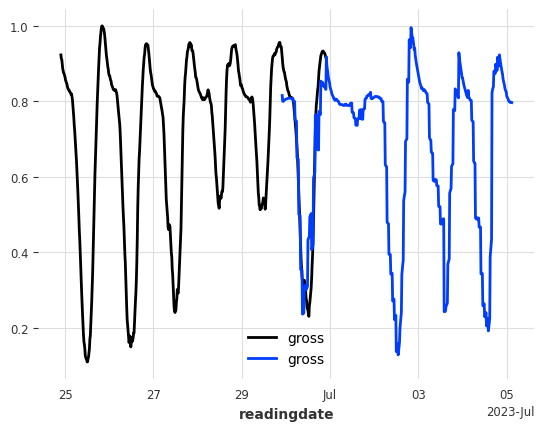

In [87]:
from darts.metrics import mape, smape, mae

# regr_model.predict(1)
# eval_model(regr_model, val_weather)

# plot acutals against the predicted horizon
forecast, actual  = val_meter[:-96], val_meter[-96:]
# train_meter.plot()
val_meter.plot()

pred = model.predict(n=500, series=forecast, past_covariates=ats, future_covariates=wts)
pred.plot()

print("MAPE = {:.2f}%".format(mape(actual, pred)))
print("SMAPE = {:.2f}%".format(smape(actual, pred)))
print("MAE = {:.2f}%".format(mae(actual, pred)))

## Evaluate an existing model

In [98]:
import pandas as pd
from darts.timeseries import TimeSeries

from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import pytz
import pickle

In [89]:
ddf = pd.read_csv('../data/2023_07_cleaned_pv.csv', parse_dates=['readingdate']).set_index('readingdate')
# ts = TimeSeries.from_dataframe(ddf)
# ts.time_index.tz_localize('Europe/Amsterdam')

ddf.index = ddf.index.tz_localize(None).tz_localize(pytz.utc).tz_convert(AMS_TZ)

In [187]:
with open('../20240524_1337_lstm_custom_loss_lower_lr/val_results_pv_larger.pkl', 'rb') as f:
    custom_loss_predicted_pv = pickle.load(f)
    custom_loss_actuals_pv = pickle.load(f)


with open('../20240524_1331_lstm_baseline_lower_lr/val_results_pv_larger.pkl', 'rb') as f:
    base_predicted_pv = pickle.load(f)
    base_actuals_pv = pickle.load(f)


with open('../20240524_1337_lstm_custom_loss_lower_lr/val_results_non_pv.pkl', 'rb') as f:
    custom_loss_predicted_non_pv = pickle.load(f)
    custom_loss_actuals_non_pv = pickle.load(f)


with open('../20240524_1331_lstm_baseline_lower_lr/val_results_non_pv.pkl', 'rb') as f:
    base_predicted_non_pv = pickle.load(f)
    base_actuals_non_pv = pickle.load(f)

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(Europe/Amsterdam)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


<Axes: xlabel='readingdate'>

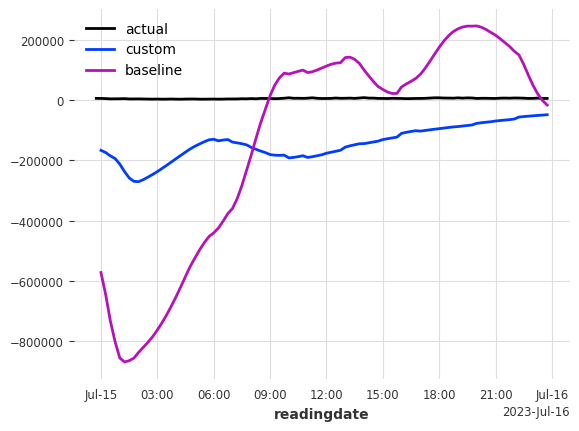

In [116]:
TimeSeries.from_dataframe(custom_loss_actuals_non_pv).plot(label='actual')
custom_loss_predicted_non_pv.plot(label='custom')
base_predicted_non_pv.plot(label='baseline')

In [127]:
custom_loss_predicted_pv

<TimeSeries (DataArray) (readingdate: 672, component: 1, sample: 1)> Size: 3kB
array([[[-176481.22 ]],

       [[-190576.6  ]],

       [[-201736.56 ]],

       [[-218332.31 ]],

       [[-246181.1  ]],

       [[-270179.3  ]],

       [[-285189.3  ]],

       [[-291144.25 ]],

       [[-288496.06 ]],

       [[-280867.4  ]],

...

       [[ -66199.82 ]],

       [[ -64763.457]],

       [[ -57642.84 ]],

       [[ -56182.58 ]],

       [[ -54830.86 ]],

       [[ -53547.855]],

       [[ -52469.67 ]],

       [[ -51279.188]],

       [[ -50128.81 ]],

       [[ -49009.652]]], dtype=float32)
Coordinates:
  * readingdate  (readingdate) datetime64[ns] 5kB 2023-07-23 ... 2023-07-29T2...
  * component    (component) object 8B 'gross'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [188]:
target = TimeSeries.from_dataframe(custom_loss_actuals_pv.iloc[1:])

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(Europe/Amsterdam)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


In [134]:
target.values().shape

(672, 1)

In [189]:
custom_loss_predicted_pv = custom_loss_predicted_pv.pd_dataframe()

In [202]:
# Group by day
df = base_predicted_pv.pd_dataframe()
df['date'] = df.index.date
grouped = df.groupby('date')

custom_loss_actuals_pv.index = custom_loss_actuals_pv.index.tz_localize(None)
# Print grouped data
for date, group in grouped:
    print(date.weekday())
    a = custom_loss_actuals_pv.loc[group.index.min():group.index.max()]
    get_metrics(TimeSeries.from_dataframe(a), TimeSeries.from_dataframe(group[['gross']]))


6
SMAPE 160.89
0
SMAPE 148.528
1
SMAPE 155.636
2
SMAPE 154.804
3
SMAPE 122.719
4
SMAPE 164.496
5
SMAPE 174.315


In [206]:
from darts.metrics.metrics import mae, mape, rmse, smape, r2_score


def get_metrics(_target, pr):
    # sMAPE
    smape_ = smape(_target, pr)
    mape_ = mape(_target, pr)
    mae_ = mae(_target, pr)
    # RMSE
    rmse_ = rmse(_target, pr)
    r2_ = r2_score(_target, pr)


    print(f'''
        SMAPE {round(smape_, 3)}
        MAPE  {round(mape_, 3)}
        MAE   {round(mae_, 3)}
        RMSE  {round(rmse_, 3)}
        R2    {round(r2_, 3)}
        ''')


get_metrics(TimeSeries.from_dataframe(custom_loss_actuals_pv.iloc[1:]), TimeSeries.from_dataframe(custom_loss_predicted_pv[['gross']]))
get_metrics(TimeSeries.from_dataframe(base_actuals_pv.iloc[1:]), base_predicted_pv)


The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(Europe/Amsterdam)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.



        SMAPE 149.653
        MAPE  290.549
        MAE   184700.041
        RMSE  205094.838
        R2    -0.364
        

        SMAPE 154.484
        MAPE  343.96
        MAE   243816.737
        RMSE  287364.76
        R2    -1.678
        


The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(Europe/Amsterdam)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


<Axes: xlabel='readingdate'>

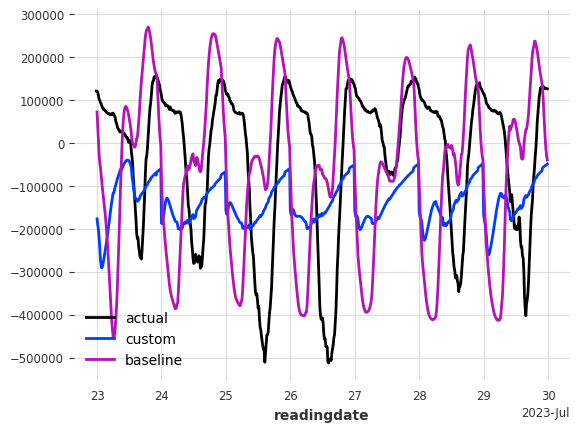

In [122]:
TimeSeries.from_dataframe(custom_loss_actuals_pv).plot(label='actual')
custom_loss_predicted_pv.plot(label='custom')
base_predicted_pv.plot(label='baseline')

<Axes: xlabel='readingdate'>

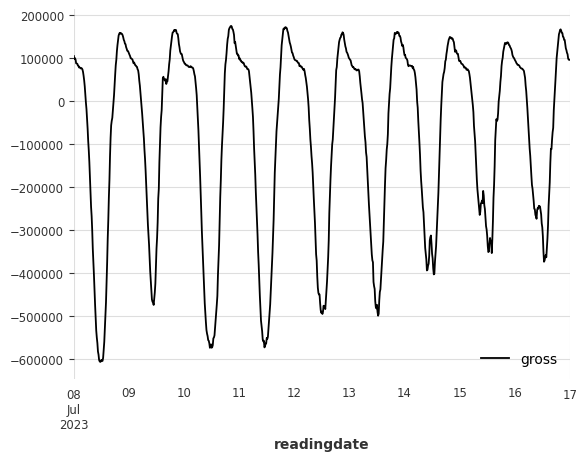

In [95]:
ddf['2023-07-08 00:00':'2023-07-17 00:00']

In [84]:
import pytz
AMS_TZ = pytz.timezone('Europe/Amsterdam')

start_date = pd.Timestamp(2023, 7, 8, 0, 0, tzinfo=None)
end_date = dt.datetime(2023, 7, 16, 0, 0)

In [91]:
ddf[ddf.index > end_date]

TypeError: Invalid comparison between dtype=datetime64[ns, UTC] and datetime

In [88]:
ts[ts.time_index >= start_date]

IndexError: The type of your index was not matched.


IndexError: The type of your index was not matched.

In [52]:
ts.min(axis=0)

<TimeSeries (DataArray) (readingdate: 1, component: 1, sample: 1)> Size: 8B
array([[[60503.]]])
Coordinates:
  * readingdate  (readingdate) datetime64[ns] 8B 2023-04-30T22:00:00
  * component    (component) object 8B 'gross'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [58]:
val_df = pd.read_csv('./2023_06_cleaned_pv.csv', parse_dates=['readingdate']).set_index('readingdate')
val_df = TimeSeries.from_dataframe(val_df, freq='15min')
# val_df.add_datetime_attribute('weekday', one_hot=True)

actuals_df = pd.read_csv('./2023-06-amsterdam-actuals.csv', parse_dates=['datetime_from']).set_index('datetime_from')[['wind_speed', 'global_radiation', 'air_pressure', 'air_temperature']]
actuals_df = actuals_df.resample('15min').mean()
actuals_df = TimeSeries.from_dataframe(actuals_df, freq='15min')

forecasts_df = pd.read_csv('../2023_weather_data_06_run_summer.csv', parse_dates=['valid_datetime']).set_index('valid_datetime')[['wind_speed_10m', 'grad_accum_ground_0m', 'pres_instant_ground_0m', 't_instant_ground_2m']]
forecasts_df = forecasts_df.resample('15min').ffill()
forecasts_df = TimeSeries.from_dataframe(forecasts_df,freq='15min')

# scaling
weather_forecast_scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))
weather_actuals_scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))
smart_meter_scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))

val_df = smart_meter_scaler.fit_transform(val_df)
actuals_df = weather_actuals_scaler.fit_transform(actuals_df)
forecasts_df = weather_forecast_scaler.fit_transform(forecasts_df)


The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


In [59]:
from src.neuro_symbolic_demand_forecasting.darts.custom_modules import ExtendedRNNModel

# loaded_model = ExtendedRNNModel.load_from_checkpoint('LSTM_P4_with_MSE', work_dir='/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting/darts_logs', best=False)
# loaded_model_custom = ExtendedRNNModel.load_from_checkpoint('LSTM_P4_with_CustomLoss', work_dir='/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting/darts_logs', best=False)
custom_loss_model = ExtendedRNNModel.load('../lstm_custom_loss.pkl')
mse_loss_model = ExtendedRNNModel.load('../lstm_mse_loss.pkl')

/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.12/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.4, which is newer than your current Lightning version: v2.2.3
/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.12/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.12/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.4, which is newer than your current Lightning version: 

In [60]:
# predict = loaded_model.predict(n=96, series=val_df[100:772], past_covariates=actuals_df, future_covariates=forecasts_df)
predict_custom = custom_loss_model.predict(n=96, series=val_df[100:772], future_covariates=forecasts_df)
predict = mse_loss_model.predict(n=96, series=val_df[100:772], future_covariates=forecasts_df)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [48]:
predict['gross']

<TimeSeries (DataArray) (readingdate: 96, component: 1, sample: 1)> Size: 768B
array([[[0.93545361]],

       [[0.92757487]],

       [[0.92111857]],

       [[0.91559006]],

       [[0.90768523]],

       [[0.90122307]],

       [[0.89515636]],

       [[0.88930009]],

       [[0.8823969 ]],

       [[0.87588215]],

...

       [[0.95858629]],

       [[0.96233826]],

       [[0.96893003]],

       [[0.97434141]],

       [[0.97831808]],

       [[0.9807438 ]],

       [[0.98412033]],

       [[0.98606437]],

       [[0.98716138]],

       [[0.98751024]]])
Coordinates:
  * readingdate  (readingdate) datetime64[ns] 768B 2023-06-08T22:00:00 ... 20...
  * component    (component) object 8B 'gross'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='readingdate'>

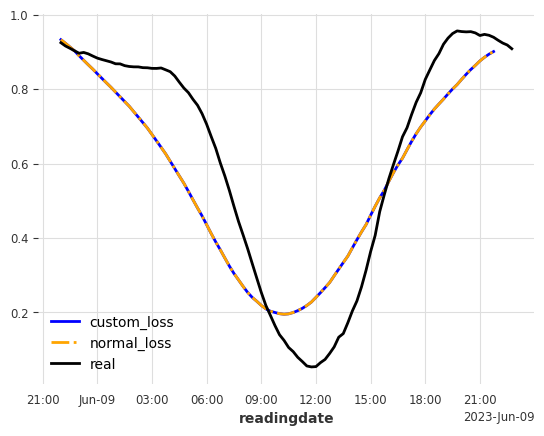

In [86]:
predict_custom['gross'].plot(label='custom_loss', **{'linestyle': 'solid', 'color': 'blue'})
predict['gross'].plot(label='normal_loss', **{'linestyle': '-.', 'color': 'orange'})
val_df[772:772+100].plot(label='real')

### Explainability

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

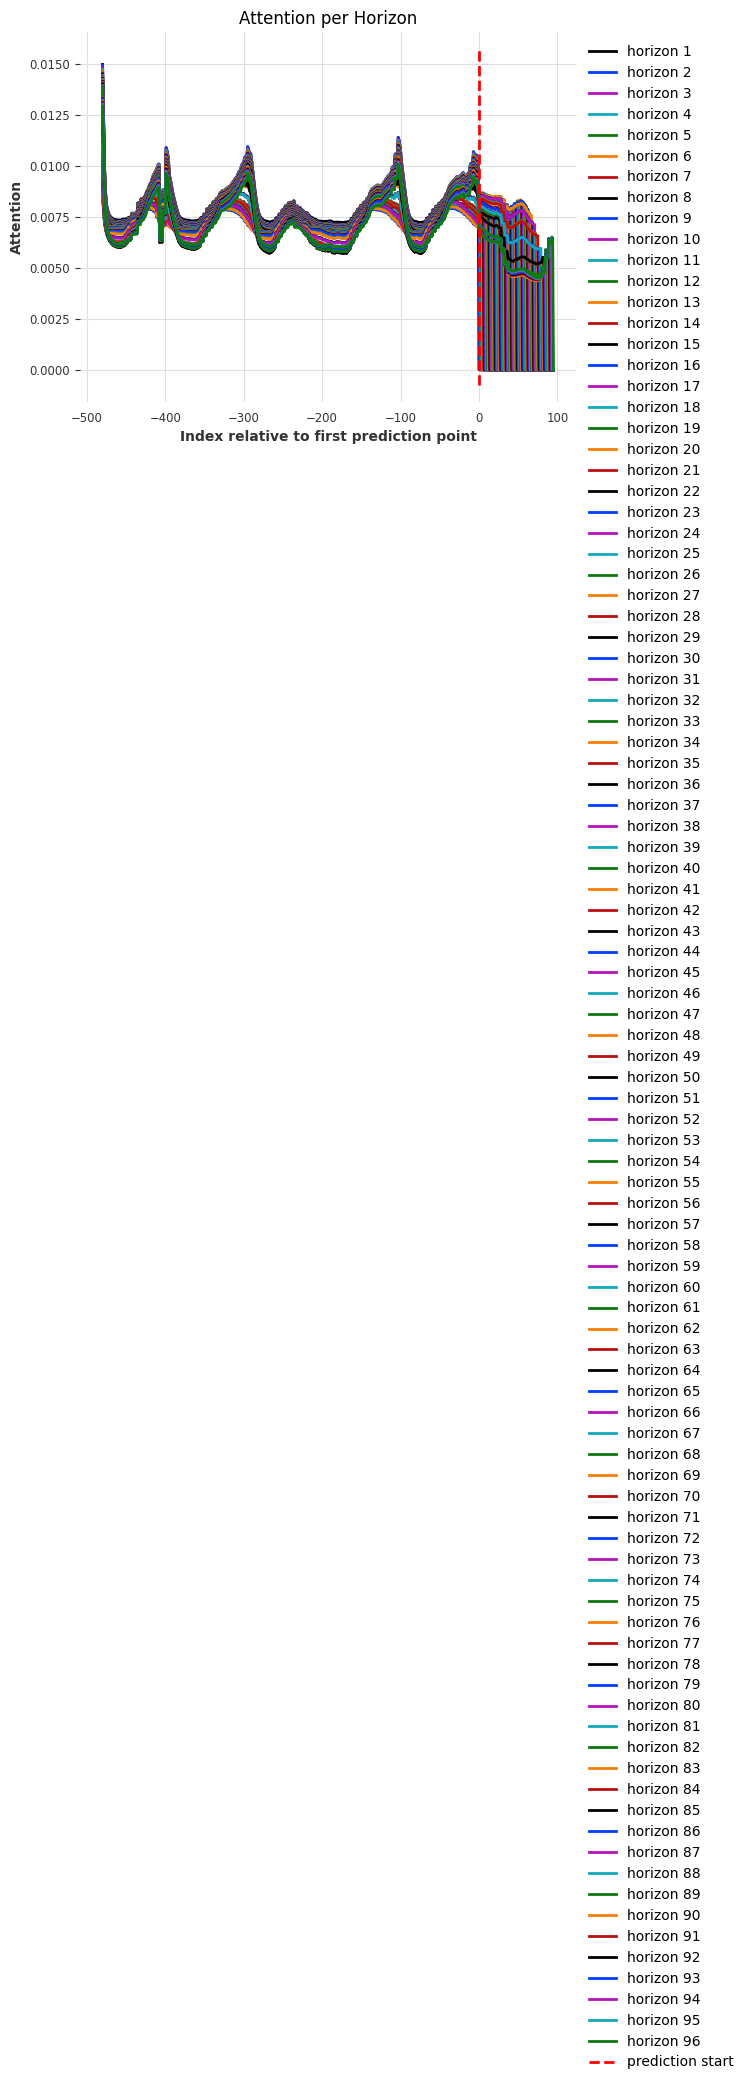

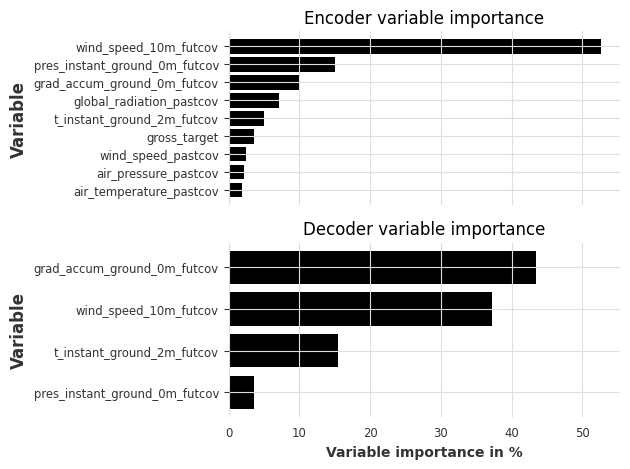

In [88]:
from darts.explainability.tft_explainer import TFTExplainer

explainer = TFTExplainer(model)
results = explainer.explain()
# plot the results
explainer.plot_attention(results, plot_type="all")
explainer.plot_variable_selection(results)

## Finding feature columns from tensor training batches

In [233]:
from os import listdir
from os.path import isfile, join
batch_path = '../debug'
onlyfiles = [f for f in listdir(batch_path) if isfile(join(batch_path, f)) and not "encode" in f]
onlyfiles.sort()
list(enumerate(onlyfiles))

[(0, '0_batch_00_tensor_00_slice.csv'),
 (1, '0_batch_01_tensor_00_slice.csv'),
 (2, '0_batch_01_tensor_01_slice.csv'),
 (3, '0_batch_01_tensor_02_slice.csv'),
 (4, '0_batch_01_tensor_03_slice.csv'),
 (5, '0_batch_02_tensor_00_slice.csv'),
 (6, '0_batch_02_tensor_01_slice.csv'),
 (7, '0_batch_02_tensor_02_slice.csv'),
 (8, '0_batch_02_tensor_03_slice.csv'),
 (9, '0_batch_03_tensor_00_slice.csv'),
 (10, '0_batch_03_tensor_01_slice.csv'),
 (11, '0_batch_03_tensor_02_slice.csv'),
 (12, '0_batch_03_tensor_03_slice.csv')]

In [226]:
from os import listdir
from os.path import isfile, join
batch_path = '../debug'
onlyfiles = [f for f in listdir(batch_path) if isfile(join(batch_path, f)) and "encode" in f]
onlyfiles.sort()
list(enumerate(onlyfiles))

[(0, '0_encoded_batch_00_tensor_00_slice.csv'),
 (1, '0_encoded_batch_01_tensor_00_slice.csv'),
 (2, '0_encoded_batch_01_tensor_01_slice.csv'),
 (3, '0_encoded_batch_01_tensor_02_slice.csv'),
 (4, '0_encoded_batch_01_tensor_03_slice.csv'),
 (5, '0_encoded_batch_01_tensor_04_slice.csv'),
 (6, '0_encoded_batch_01_tensor_05_slice.csv'),
 (7, '0_encoded_batch_02_tensor_00_slice.csv'),
 (8, '0_encoded_batch_02_tensor_01_slice.csv'),
 (9, '0_encoded_batch_02_tensor_02_slice.csv'),
 (10, '0_encoded_batch_02_tensor_03_slice.csv'),
 (11, '0_encoded_batch_02_tensor_04_slice.csv'),
 (12, '0_encoded_batch_02_tensor_05_slice.csv'),
 (13, '0_encoded_batch_03_tensor_00_slice.csv'),
 (14, '0_encoded_batch_03_tensor_01_slice.csv'),
 (15, '0_encoded_batch_03_tensor_02_slice.csv'),
 (16, '0_encoded_batch_03_tensor_03_slice.csv'),
 (17, '0_encoded_batch_03_tensor_04_slice.csv'),
 (18, '0_encoded_batch_03_tensor_05_slice.csv')]

In [227]:
dfs = [pd.read_csv(f'{batch_path}/{f}') for f in onlyfiles]
dfs[0]

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,-1340166.0,-1366976.0,-1365573.0,-1367162.0,-1373745.0,-1372186.0,-1365277.0,-1359439.0,-1345337.0,-1325772.0,...,-720031.0,-794700.0,-867931.0,-921936.0,-979769.0,-1027472.0,-1084847.0,-1142136.0,-1190073.0,-1226295.0
1,-236143.0,-183667.0,-106157.0,-59735.0,-5163.0,59281.0,123104.0,191534.0,221138.0,253393.0,...,-1121395.0,-1062007.0,-997049.0,-905651.0,-822101.0,-716237.0,-600674.0,-481484.0,-382095.0,-301183.0
2,182359.0,179540.0,180954.0,179379.0,184732.0,177152.0,175332.0,170774.0,172628.0,161367.0,...,252485.0,245633.0,234950.0,232693.0,230373.0,227055.0,217262.0,217192.0,212594.0,207518.0
3,348644.0,336072.0,319762.0,302786.0,289459.0,275334.0,258057.0,251948.0,247520.0,228155.0,...,347143.0,374271.0,412872.0,416203.0,429857.0,425806.0,412607.0,419068.0,402314.0,391923.0
4,-1294957.0,-1307393.0,-1296323.0,-1269000.0,-1230496.0,-1197892.0,-1169721.0,-1104926.0,-1067746.0,-1005867.0,...,-1051129.0,-1091043.0,-1122540.0,-1153344.0,-1180048.0,-1196500.0,-1201980.0,-1217071.0,-1208759.0,-1205302.0
5,-630937.0,-673785.0,-702443.0,-747582.0,-780456.0,-804592.0,-831085.0,-874144.0,-926155.0,-948688.0,...,-663671.0,-733424.0,-808218.0,-882345.0,-955641.0,-1021346.0,-1071884.0,-1123415.0,-1169929.0,-1198840.0
6,136147.0,102376.0,66139.0,24455.0,-15983.0,-59956.0,-107402.0,-156366.0,-203273.0,-257469.0,...,189846.0,185264.0,181790.0,178052.0,173986.0,173277.0,171359.0,167948.0,163463.0,152500.0
7,362509.0,380787.0,382413.0,395999.0,396704.0,384477.0,364195.0,360063.0,343844.0,327960.0,...,-96997.0,-20013.0,29481.0,86015.0,152649.0,203519.0,252803.0,293253.0,328044.0,361688.0
8,-374038.0,-449470.0,-527296.0,-609676.0,-700696.0,-780958.0,-858474.0,-945197.0,-1020128.0,-1080271.0,...,164217.0,152260.0,136485.0,117069.0,78474.0,45275.0,2944.0,-53753.0,-112664.0,-155276.0
9,-1241475.0,-1294753.0,-1340166.0,-1366976.0,-1365573.0,-1367162.0,-1373745.0,-1372186.0,-1365277.0,-1359439.0,...,-569585.0,-643326.0,-720031.0,-794700.0,-867931.0,-921936.0,-979769.0,-1027472.0,-1084847.0,-1142136.0


In [232]:
dfs[5].describe()

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,2.812500,2.843750,2.875000,2.875000,2.875000,2.875000,2.875000,2.906250,2.937500,2.968750,...,2.937500,2.937500,2.937500,2.937500,2.968750,3.000000,3.000000,3.000000,3.000000,2.812500
std,1.925005,1.919499,1.930235,1.930235,1.930235,1.930235,1.930235,1.906853,1.865433,1.908967,...,1.982789,1.982789,1.982789,1.982789,1.975403,1.934408,1.934408,1.934408,1.934408,1.925005
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000


In [211]:
[print(d.shape) for d in dfs]

(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 96)
(32, 96)
(32, 96)
(32, 96)
(32, 96)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [141]:
n = dfs[5]
m = dfs[9]
m

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.834593,1.834593,1.988579,1.988579,1.988579,1.988579,1.870757,1.870757,1.870757,1.870757,...,1.249977,1.249977,1.249977,1.249977,1.560027,1.560027,1.560027,1.560027,1.808022,1.808022
1,3.406696,3.406696,3.406696,3.406696,3.210056,3.210056,3.210056,3.210056,3.283361,3.283361,...,4.145731,4.145731,4.206111,4.206111,4.206111,4.206111,3.875983,3.875983,3.875983,3.875983
2,5.525506,5.525506,5.396968,5.396968,5.396968,5.396968,5.127884,5.127884,5.127884,5.127884,...,4.835532,4.835532,4.835532,4.835532,5.272175,5.272175,5.272175,5.272175,5.595923,5.595923
3,1.710040,1.710040,1.710040,1.916040,1.916040,1.916040,1.916040,2.167682,2.167682,2.167682,...,4.143808,4.204272,4.204272,4.204272,4.204272,3.516125,3.516125,3.516125,3.516125,3.049135
4,2.479171,2.479171,2.479171,2.479171,2.331807,2.331807,2.331807,2.331807,1.753839,1.753839,...,4.787810,4.787810,1.741210,1.741210,1.741210,1.741210,1.747325,1.747325,1.747325,1.747325
5,4.317928,4.317928,4.317928,4.317928,3.835572,3.835572,3.835572,3.835572,3.944538,3.944538,...,2.745438,2.745438,3.135687,3.135687,3.135687,3.135687,2.737386,2.737386,2.737386,2.737386
6,2.654253,2.914748,2.914748,2.914748,2.914748,3.220103,3.220103,3.220103,3.220103,3.858098,...,3.461101,3.461101,3.461101,3.094804,3.094804,3.094804,3.094804,3.274557,3.274557,3.274557
7,2.555571,2.031704,2.031704,2.031704,2.031704,2.546020,2.546020,2.546020,2.546020,2.845944,...,2.091621,2.091621,2.091621,2.316888,2.316888,2.316888,2.316888,2.138129,2.138129,2.138129
8,2.355386,2.355386,2.355386,2.355386,1.430747,1.430747,1.430747,1.430747,1.156683,1.156683,...,2.479171,2.479171,2.331807,2.331807,2.331807,2.331807,1.753839,1.753839,1.753839,1.753839
9,3.912131,3.912131,3.463387,3.463387,3.463387,3.463387,3.129776,3.129776,3.129776,3.129776,...,5.525506,5.525506,5.525506,5.525506,5.396968,5.396968,5.396968,5.396968,5.127884,5.127884


<Axes: >

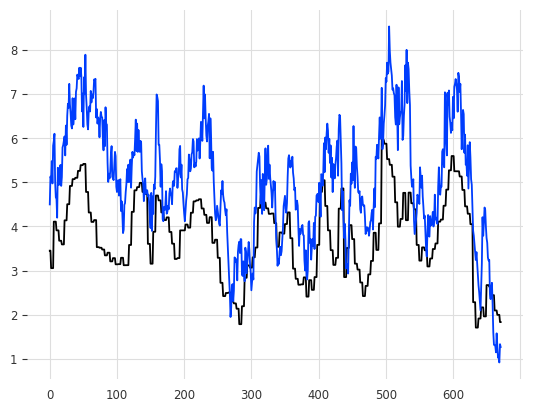

In [139]:
n.iloc[0,:].plot()
m.iloc[0,:].plot()

In [10]:
from darts.timeseries import TimeSeries

smart_meter_tss = TimeSeries.from_dataframe(sm[0])

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


In [46]:
sm

,gross
readingdate,
2023-05-31 23:00:00+02:00,0
2023-05-31 23:15:00+02:00,363576
2023-05-31 23:30:00+02:00,352240
2023-05-31 23:45:00+02:00,331535
2023-06-01 00:00:00+02:00,312404
...,...
2023-06-30 22:45:00+02:00,364599
2023-06-30 23:00:00+02:00,357906
2023-06-30 23:15:00+02:00,354801


In [48]:
from astral import LocationInfo
import datetime as dt
import pytz
from astral.sun import sun

city = LocationInfo("Amsterdam", "Netherlands", "Europe/Amsterdam")
city.observer

ams = pytz.timezone('Europe/Amsterdam')
print(ams)


d = (dt.datetime.strptime('2023-05-31 21:00+0000', "%Y-%m-%d %H:%M%z")).astimezone(ams)
print(d)
sm.index = sm.index.tz_convert(ams)

s = sun(city.observer, date=sm.index[0])
s

Europe/Amsterdam
2023-05-31 23:00:00+02:00


{'dawn': datetime.datetime(2023, 5, 31, 5, 4, 12, 509423, tzinfo=<DstTzInfo 'Europe/Amsterdam' CEST+2:00:00 DST>),
 'sunrise': datetime.datetime(2023, 5, 31, 5, 50, 9, 217728, tzinfo=<DstTzInfo 'Europe/Amsterdam' CEST+2:00:00 DST>),
 'noon': datetime.datetime(2023, 5, 31, 11, 57, 44, tzinfo=datetime.timezone.utc),
 'sunset': datetime.datetime(2023, 5, 31, 22, 5, 51, 564686, tzinfo=<DstTzInfo 'Europe/Amsterdam' CEST+2:00:00 DST>),
 'dusk': datetime.datetime(2023, 5, 31, 22, 52, 1, 652368, tzinfo=<DstTzInfo 'Europe/Amsterdam' CEST+2:00:00 DST>)}

In [101]:
def get_part_of_day(s):
    i = s.name
    sun_info = sun(city.observer, date=i.date())
    sunrise = sun_info['sunrise'].astimezone(ams).time()
    sunset = sun_info['sunset'].astimezone(ams).time()

    
    if i.time() < sunrise or i.time() > sunset:
        return 'Night'
    elif sunrise <= i.time() < dt.time(9, 0, 0):
        return 'Morning'
    elif dt.time(9, 0, 0) <= i.time() < dt.time(13,0,0):
        return 'Midday'
    elif dt.time(13, 0, 0) <= i.time() < dt.time(17, 0, 0):
        return 'Afternoon'
    else:
        return 'Evening'

sm['part_of_day'] = sm.apply(lambda x : get_part_of_day(x), axis=1)
# sm.iloc[700:750]

AttributeError: 'Series' object has no attribute 'columns'

In [123]:
sm['has_pv'] = True
sm

,gross,part_of_day,has_pv
readingdate,,,
2023-05-31 23:00:00+02:00,0,Night,True
2023-05-31 23:15:00+02:00,363576,Night,True
2023-05-31 23:30:00+02:00,352240,Night,True
2023-05-31 23:45:00+02:00,331535,Night,True
2023-06-01 00:00:00+02:00,312404,Night,True
...,...,...,...
2023-06-30 22:45:00+02:00,364599,Night,True
2023-06-30 23:00:00+02:00,357906,Night,True
2023-06-30 23:15:00+02:00,354801,Night,True


In [203]:
wa

,wind_speed_10m,grad_accum_ground_0m,pres_instant_ground_0m,t_instant_ground_2m
valid_datetime,,,,
2023-04-01 00:00:00+02:00,5.080210,0.0,98975.190,282.15723
2023-04-01 00:15:00+02:00,5.080210,0.0,98975.190,282.15723
2023-04-01 00:30:00+02:00,5.080210,0.0,98975.190,282.15723
2023-04-01 00:45:00+02:00,5.080210,0.0,98975.190,282.15723
2023-04-01 01:00:00+02:00,4.670426,0.0,98986.190,282.03906
...,...,...,...,...
2023-07-31 22:00:00+02:00,3.308534,0.0,100009.875,289.52185
2023-07-31 22:15:00+02:00,3.308534,0.0,100009.875,289.52185
2023-07-31 22:30:00+02:00,3.308534,0.0,100009.875,289.52185


In [206]:
past_covariates = sm[['part_of_day', 'has_pv']]
TimeSeries.from_dataframe(wa).stack(TimeSeries.from_dataframe(past_covariates))

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(Europe/Amsterdam)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(Europe/Amsterdam)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


ValueError: could not convert string to float: 'Night'

In [192]:
from darts.timeseries import TimeSeries

static_cov = pd.DataFrame([[1]], columns=["has_pv"])
past_covariates = sm[['part_of_day', 'has_pv']]

ts = TimeSeries.from_dataframe(sm, value_cols=['gross'])
# ts_multi = ts.stack(ts)
ts.with_static_covariates(static_cov).static_covariates




The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(Europe/Amsterdam)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


static_covariates,has_pv
component,
gross,1.0


In [17]:
from darts.timeseries import TimeSeries
import numpy as np

In [15]:
import pandas as pd
df = pd.read_csv('../data/2023_05_cleaned_pv.csv', parse_dates=['readingdate']).set_index('readingdate')
df_1 = pd.read_csv('../data/2023_06_cleaned_pv.csv', parse_dates=['readingdate']).set_index('readingdate')

In [18]:
smart_meter_tss = [TimeSeries.from_dataframe(s).astype(np.float32) for s in [df, df_1]]

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


[<Axes: xlabel='readingdate'>, <Axes: xlabel='readingdate'>]

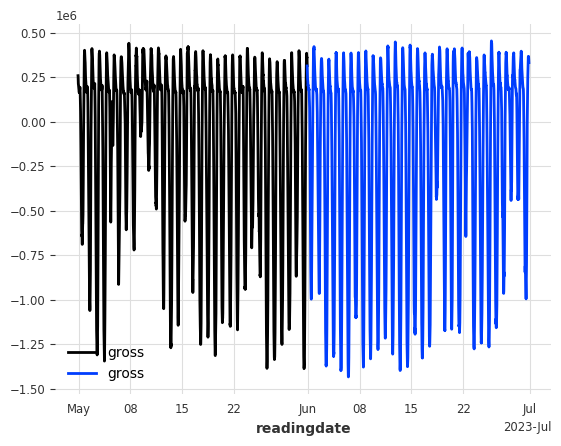

In [20]:
[s.plot() for s in smart_meter_tss]

In [11]:
df.describe()
# df_1.plot()

,gross
count,2.976000e+03
mean,-1.286595e+05
std,4.928264e+05
min,-1.388359e+06
25%,-4.848232e+05
50%,1.317410e+05
75%,2.270318e+05
max,4.400010e+05


In [4]:
df

'../data/data/2023_05_cleaned_pv.csv'

In [ ]:

ts_multi.with_static_covariates(multi)
# TimeSeries.from_dataframe(sm, value_cols=['gross']).with_static_covariates(sm['part_of_day']).with_static_covariates(sm['has_pv'])

In [11]:
smart_meter_tss.with_static_covariates

<TimeSeries (DataArray) (readingdate: 2884, component: 1, sample: 1)> Size: 23kB
array([[[     0.]],

       [[363576.]],

       [[352240.]],

       ...,

       [[354801.]],

       [[346129.]],

       [[331224.]]])
Coordinates:
  * readingdate  (readingdate) datetime64[ns] 23kB 2023-05-31T21:00:00 ... 20...
  * component    (component) object 8B 'gross'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [5]:
# 2023_06_cleaned_pv.csv 
# 2023-06-amsterdam-actuals.csv 
# ../2023_weather_data_06_run_summer.csv
import yaml
from src.neuro_symbolic_demand_forecasting.main_train import _load_csvs

model_config = {}
with open('../model_config.yaml', 'r') as file:
    model_config = yaml.safe_load(file)

sm, wa, wf = _load_csvs(model_config, ['2023_06_cleaned_pv.csv'],['../2023_weather_data_06_run_summer.csv'],  ['2023-06-amsterdam-actuals.csv'])

/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.11/lib/python3.11/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [112]:
readings = dfs[0]

In [119]:
# checking the start values of 0thtensor_0th_slice
print(sm[sm['gross']== 28602.0])
print(sm[sm['gross']== 184896.0])
print(sm[sm['gross']== 382217.0])
print(sm[sm['gross']== -400591.0])
print(sm[sm['gross']== -1151372.0])

                           gross
readingdate                     
2023-06-08 05:30:00+00:00  28602
                            gross
readingdate                      
2023-06-02 03:00:00+00:00  184896
                            gross
readingdate                      
2023-06-07 20:15:00+00:00  382217
                            gross
readingdate                      
2023-06-10 16:00:00+00:00 -400591
                             gross
readingdate                       
2023-06-08 14:00:00+00:00 -1151372
